# Denoise algorithm

This notebook defines the denoise algorithm (step C defined in Towsey 2013) and compares the speed of different implementations. This is a step in processing recordings of the natural environment that "better preserves the structural integrity of complex acoustic events (e.g. bird calls) but removes noise from background locations further removed from that event (Towsey 2013)."

[Towsey, Michael W. (2013)](http://eprints.qut.edu.au/61399/) Noise removal from wave-forms and spectrograms derived from natural recordings of the environment.

#### Required packages

[numba](https://github.com/numba/numba) <br />
[scipy](https://github.com/scipy/scipy) <br />
[numpy](https://github.com/numpy/numpy) <br />
[matplotlib](https://github.com/matplotlib/matplotlib) <br />
[pyprind](https://github.com/rasbt/pyprind)

#### Import statements

In [1]:
import numpy as np
from scipy.ndimage import generic_filter
from numba import jit, guvectorize, float64
import pyprind
import matplotlib.pyplot as plt
%matplotlib inline

## python

implementation using pure python

In [2]:
def denoise(a, b):
    for channel in range(2):
        for f_band in range(4, a.shape[1] - 4):
            for t_step in range(1, a.shape[2] - 1):
                neighborhood = a[channel, f_band - 4:f_band + 5, t_step - 1:t_step + 2]
                if neighborhood.mean() < 10:
                    b[channel, f_band, t_step] = neighborhood.min()
                else:
                    b[channel, f_band, t_step] = neighborhood[4, 1]
    return b

## scipy

implementation using scipy.ndimage.generic_filter—the custom callback function is just-in-time compiled by numba

In [3]:
@jit(nopython=True)
def filter_denoise(neighborhood):
    if neighborhood.mean() < 10:
        return neighborhood.min()
    else:
        return neighborhood[13]

In [4]:
def denoise_scipy(a, b):
        for channel in range(2):
            b[channel] = generic_filter(input=a[channel], function=filter_denoise, 
                                        size=(9, 3), mode='constant')
        return b

## numba

implementation of a universal function (ufunc) via numba.guvectorize

In [5]:
# just removed return statement
def denoise_guvectorize(a, b):
    for channel in range(2):
        for f_band in range(4, a.shape[1] - 4):
            for t_step in range(1, a.shape[2] - 1):
                neighborhood = a[channel, f_band - 4:f_band + 5, t_step - 1:t_step + 2]
                if neighborhood.mean() < 10:
                    b[channel, f_band, t_step] = neighborhood.min()
                else:
                    b[channel, f_band, t_step] = neighborhood[4, 1]

serial version

In [6]:
denoise_numba = guvectorize('float64[:,:,:], float64[:,:,:]', '(c,f,t)->(c,f,t)', 
                            nopython=True)(denoise_guvectorize)

parallel version

In [7]:
denoise_parallel = guvectorize('float64[:,:,:], float64[:,:,:]', '(c,f,t)->(c,f,t)', 
                               nopython=True, target='parallel')(denoise_guvectorize)

## check results

test the implementations on a randomly generated dataset and verfiy that all the results are the same

In [8]:
size = 100
data = np.random.rand(2, size, int(size*1.5))
data[:, int(size/4):int(size/2), int(size/4):int(size/2)] = 27

In [9]:
result_python = denoise(data, np.zeros_like(data))
result_scipy = denoise_scipy(data, np.zeros_like(data))
result_numba = denoise_numba(data, np.zeros_like(data))
result_parallel = denoise_parallel(data, np.zeros_like(data))

check if the different implementations produce the same result

In [10]:
assert np.allclose(result_python, result_scipy) and np.allclose(result_python, result_numba)

plot results

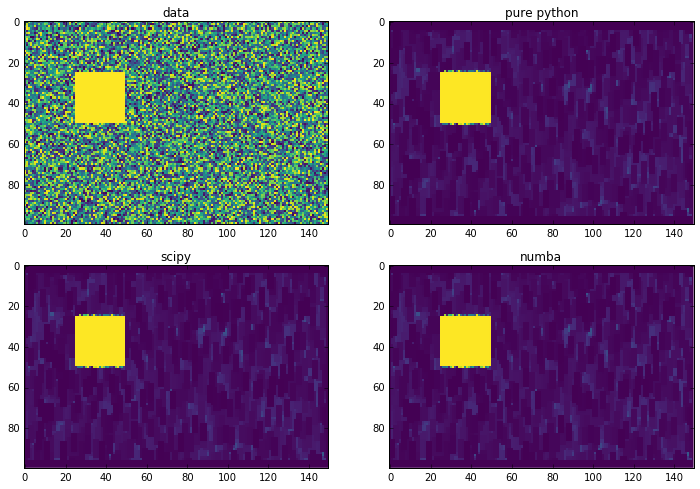

In [11]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(12)
im1 = ax[0, 0].imshow(data[0], cmap='viridis', interpolation='none', vmax=1)
t1 = ax[0, 0].set_title('data')
im2 = ax[0, 1].imshow(result_python[0], cmap='viridis', interpolation='none', vmax=1)
t1 = ax[0, 1].set_title('pure python')
im3 = ax[1, 0].imshow(result_scipy[0], cmap='viridis', interpolation='none', vmax=1)
t1 = ax[1, 0].set_title('scipy')
im4 = ax[1, 1].imshow(result_numba[0], cmap='viridis', interpolation='none', vmax=1)
t1 = ax[1, 1].set_title('numba')

## profile for different data sizes

time the different implementations on different dataset sizes

In [12]:
sizes = [30, 50, 100, 200, 400, 800, 1600]

In [13]:
progress_bar = pyprind.ProgBar(iterations=len(sizes), track_time=True, stream=1, monitor=True)
t_python = np.empty_like(sizes, dtype=np.float64)
t_scipy = np.empty_like(sizes, dtype=np.float64)
t_numba = np.empty_like(sizes, dtype=np.float64)
t_parallel = np.empty_like(sizes, dtype=np.float64)
for size in range(len(sizes)):
    progress_bar.update(item_id=sizes[size])
    data = np.random.rand(2, sizes[size], sizes[size])*0.75
    t_1 = %timeit -oq denoise(data, np.zeros_like(data))
    t_2 = %timeit -oq denoise_scipy(data, np.zeros_like(data))
    t_3 = %timeit -oq denoise_numba(data, np.zeros_like(data))
    t_4 = %timeit -oq denoise_parallel(data, np.zeros_like(data))
    t_python[size] = t_1.best
    t_scipy[size] = t_2.best
    t_numba[size] = t_3.best
    t_parallel[size] = t_4.best

0%   100%
[#######] | ETA: 00:00:00 | Item ID: 1600
Total time elapsed: 00:02:30


plot profile results

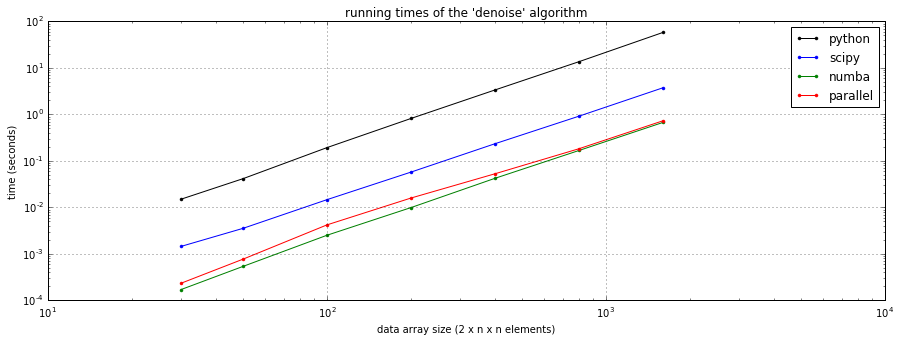

In [14]:
fig, ax = plt.subplots(figsize=(15,5))
p1 = ax.loglog(sizes, t_python, color='black', marker='.', label='python')
p2 = ax.loglog(sizes, t_scipy, color='blue', marker='.', label='scipy')
p3 = ax.loglog(sizes, t_numba, color='green', marker='.', label='numba')
p4 = ax.loglog(sizes, t_parallel, color='red', marker='.', label='parallel')
lx = ax.set_xlabel("data array size (2 x n x n elements)")
ly = ax.set_ylabel("time (seconds)")
t1 = ax.set_title("running times of the 'denoise' algorithm")
ax.grid(True, which='major')
l = ax.legend()

## conclusion

use the serial numba implementation